# Lab 3: Deep Q-learning Network

In [13]:
!pip install gym==0.13.0   #lower the gym Edition

Looking in indexes: https://mirrors.cernet.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.13.0-py3-none-any.whl size=1634649 sha256=aa3e3e0a73f779c9aa120b32e7471792903f8a074586cbcc16cec52eff9260c3
  Stored in directory: /Users/lixingyu/Library/Caches/pip/wheels/83/4c/cf/2fa9239958868ec0f4c9f817567b34e11b5e2185e1247b3ca2
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.0
    Uninstalling cloudpickle-3.1.0:
      Successfully uninstalled cloudpickle-3.1.0
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2


Double layers q-learning network with windygrid world 

In [1]:
#import all needed library
import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np     

In [17]:
# Define the windyGridWorld environment
class WindyGridWorld(gym.Env):

    def __init__(self, n_width=10, n_height=7, u_size=40, default_reward=-1):
        self.u_size = u_size
        self.n_width = n_width
        self.n_height = n_height
        self.default_reward = default_reward
        self.state = None
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.start = (0, 3)
        self.ends = [(7, 3)]
        self.reward = 0
        self.viewer = None
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(n_width * n_height)
        self.seed(33)

    def seed(self, seed=33):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        self.state = self._xy_to_state(*self.start)
        return self.state

    def step(self, action):
        assert self.action_space.contains(action), f"{action} is invalid"
        x, y = self._state_to_xy(self.state)
        new_x, new_y = x, y
        new_y += self.wind_strength[x]  # Apply wind effect

        if action == 0: new_x -= 1  # left
        elif action == 1: new_x += 1  # right
        elif action == 2: new_y += 1  # up
        elif action == 3: new_y -= 1  # down

        new_x = np.clip(new_x, 0, self.n_width - 1)   # Boundary conditions
        new_y = np.clip(new_y, 0, self.n_height - 1)

        self.state = self._xy_to_state(new_x, new_y) # Update state and check termination
        done = (new_x, new_y) in self.ends
        reward = 1 if done else self.default_reward
        return self.state, reward, done, {}
    
    def _state_to_xy(self, s):
        x = s % self.n_width
        y = s // self.n_width
        return x, y

    def _xy_to_state(self, x, y):
        return x + y * self.n_width

In [18]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, state_space_size, action_space_size):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(state_space_size, 64)  # Embed state indices into 64-dim space
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, action_space_size)
        )

    def forward(self, x):
        x = self.embedding(x.long())  # Ensure state indices are integers
        return self.net(x)

In [19]:
# Hyperparameters
gamma = 0.99
epsilon = 0.99
epsilon_min = 0.1
epsilon_decay = 0.995
learning_rate = 1e-5
batch_size = 64
memory = deque(maxlen=10000)

In [20]:
# Initialize environment and networks
env = WindyGridWorld()
state_dim = env.observation_space.n
action_dim = env.action_space.n

dqn = DQN(state_dim, action_dim)
target_dqn = DQN(state_dim, action_dim)
target_dqn.load_state_dict(dqn.state_dict()) 
target_dqn.eval()  

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [21]:
# Action selection policy
def choose_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()
    state = torch.tensor(state, dtype=torch.long)
    q_values = dqn(state)
    return torch.argmax(q_values).item()

# Training function
def train():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.tensor(states, dtype=torch.long)
    actions = torch.tensor(actions, dtype=torch.int64)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.long)
    dones = torch.tensor(dones, dtype=torch.float32)

    q_values = dqn(states).gather(1, actions.unsqueeze(-1)).squeeze(-1) # current Q-values
    next_q_values = target_dqn(next_states).max(1)[0] # next Q-values
    target_q_values = rewards + gamma * next_q_values * (1 - dones)# Compute target Q-values

    # Compute loss
    loss = loss_fn(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [23]:
# Training loop
num_episodes = 300
rewards = []
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        loss = train()

    rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Periodically update the target network
    if episode % 10 == 0:
        target_dqn.load_state_dict(dqn.state_dict())  # Copy weights from main Q-network to target Q-network
        
    print(f"Episode { episode+ 1 }, Total Reward: { total_reward }, Loss: {loss}")
    
env.close()

Episode 1, Total Reward: -12398, Loss: 2.4533577743568458e-05
Episode 2, Total Reward: -7669, Loss: 7.026053935987875e-05
Episode 3, Total Reward: -5107, Loss: 7.604684810758044e-07
Episode 4, Total Reward: -8976, Loss: 2.3384021829997437e-08
Episode 5, Total Reward: -3534, Loss: 7.787791744817696e-09
Episode 6, Total Reward: -2424, Loss: 1.1064376970182366e-08
Episode 7, Total Reward: -1887, Loss: 3.4492680356379424e-07
Episode 8, Total Reward: -1351, Loss: 9.564136007611523e-07
Episode 9, Total Reward: -3427, Loss: 1.731604726273872e-07
Episode 10, Total Reward: -15080, Loss: 3.060602216109487e-09
Episode 11, Total Reward: -7178, Loss: 4.0520742317085023e-08
Episode 12, Total Reward: -857, Loss: 0.012738119810819626
Episode 13, Total Reward: -3054, Loss: 0.00037459394661709666
Episode 14, Total Reward: -4653, Loss: 4.852010169997811e-05
Episode 15, Total Reward: -1742, Loss: 3.961541551689152e-06
Episode 16, Total Reward: -5002, Loss: 8.240780289270333e-07
Episode 17, Total Reward: -

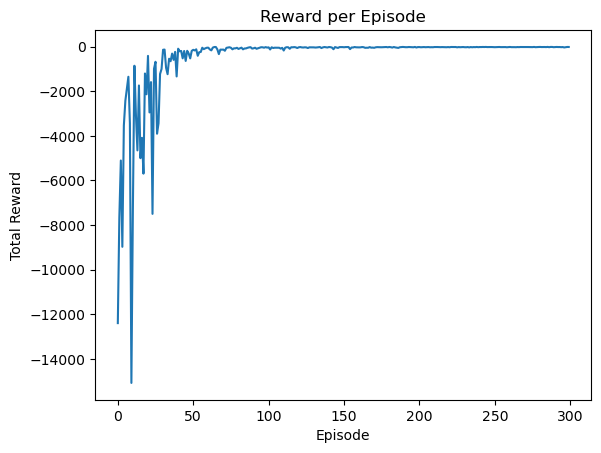

In [24]:
#draw reward per episode figure
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.show()     